# Libraries

In [28]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit
import re # for regular expressions

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # to load images

from gensim.test.utils import common_texts  # some example texts

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.naive_bayes import GaussianNB # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.svm import LinearSVC # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, mean_squared_error  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler 

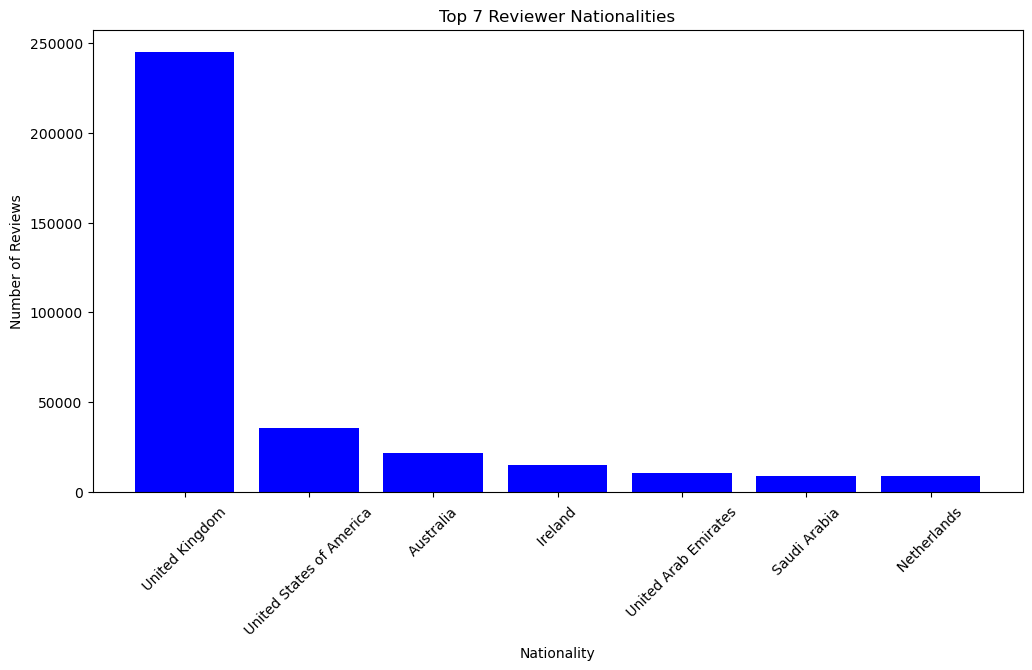

In [29]:
# Distrobution of nationality (top 7 nationalities)
df = pd.read_csv('Hotel_Reviews.csv')

top_nationalities = df['Reviewer_Nationality']. value_counts().head(7)

plt.figure(figsize=(12, 6))
plt.bar(top_nationalities.index, top_nationalities.values, color='blue')
plt.xticks(rotation=45)
plt.title("Top 7 Reviewer Nationalities")
plt.xlabel("Nationality")
plt.ylabel("Number of Reviews")
plt.show()

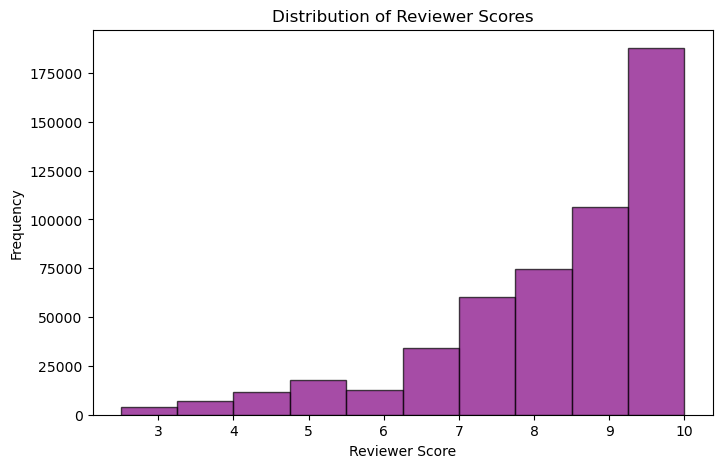

In [30]:
plt.figure(figsize=(8, 5))

# Review Score Distribution
plt.hist(df['Reviewer_Score'], bins=10, color="purple", edgecolor="black", alpha=0.7)
plt.title("Distribution of Reviewer Scores")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.show()

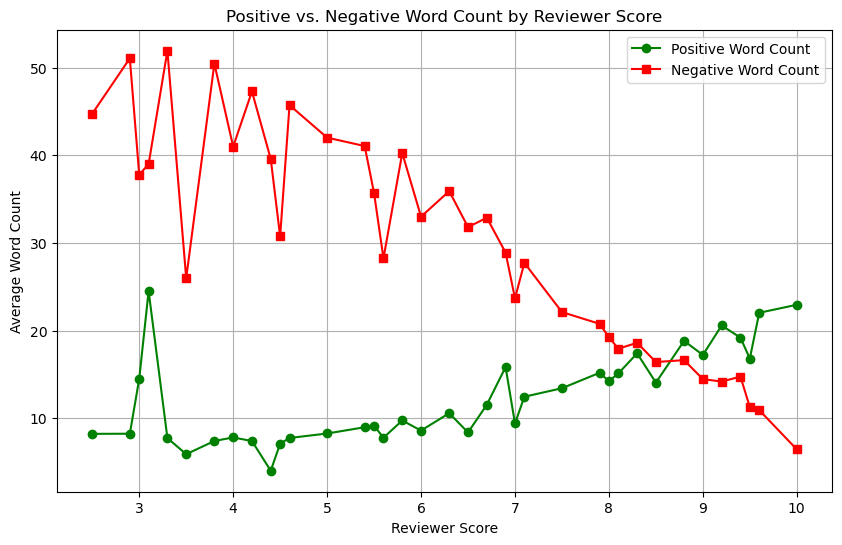

In [31]:
review_score_grouped = df.groupby("Reviewer_Score")[
    ["Review_Total_Positive_Word_Counts", "Review_Total_Negative_Word_Counts"]
].mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both lines
ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Positive_Word_Counts"],
        marker="o", linestyle="-", color="green", label="Positive Word Count")

ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Negative_Word_Counts"],
        marker="s", linestyle="-", color="red", label="Negative Word Count")

# Labels and title
ax.set_xlabel("Reviewer Score")
ax.set_ylabel("Average Word Count")
ax.set_title("Positive vs. Negative Word Count by Reviewer Score")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

In [32]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores

positive_reviews = df[df['Reviewer_Score'] > 8.5]
negative_reviews = df[df['Reviewer_Score'] < 8.5]

negative_sample = negative_reviews.sample(n=5000, random_state=42)
positive_sample = positive_reviews.sample(n=5000, random_state=42)

balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Reviewer_Score'].apply(lambda x: 'positive' if x > 8.5 else 'negative').value_counts())

Reviewer_Score
positive    5000
negative    5000
Name: count, dtype: int64


In [33]:
def replace(cell): 
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell

df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

In [34]:
def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

In [35]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,3.3,Location It was probably the Worst Hotel I h...
1,10.0,All in all just wonderful Those 25 euros pe...
2,10.0,The hotel was spotlessly clean the staff went...
3,9.6,Very friendly and helpful people Very nice bo...
4,8.8,The room is very clean and convenient The loc...
...,...,...
9995,7.9,Just next to the conf center large and comfy ...
9996,5.4,Member of my team asked to change rooms due t...
9997,7.9,The hotel decor and the swimming pool Locatio...
9998,10.0,Very cool place


In [36]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # 5. Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # 6. Join back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

In [37]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 8.5 else 1)

In [38]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

In [39]:
# Generate WordCloud function for negative and positive reviews
# source: https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

In [40]:
# We remove unrelated words that are used alot

def remove_unwaned_words(text, words_to_remove):
    return text.apply(lambda text: " ".join(word for word in text.split() if word.lower() not in words_to_remove))

unwanted_words = {'hotel', 'room', 'staff', 'bathroom', 'breakfast', 'location'}

train_pos = remove_unwaned_words(train_pos, unwanted_words)
train_neg = remove_unwaned_words(train_neg, unwanted_words)

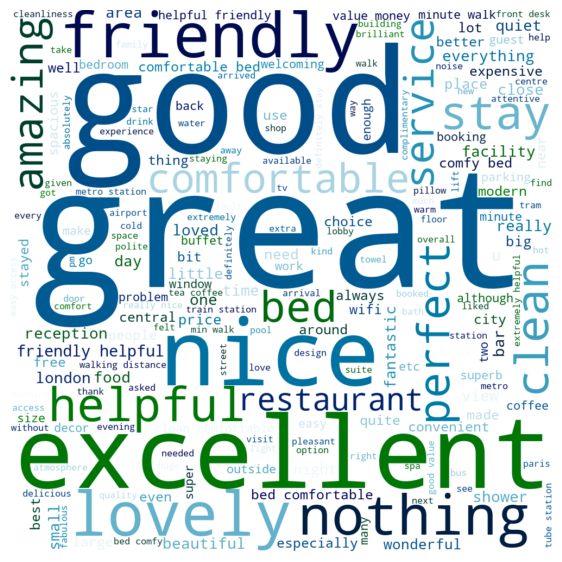

In [41]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

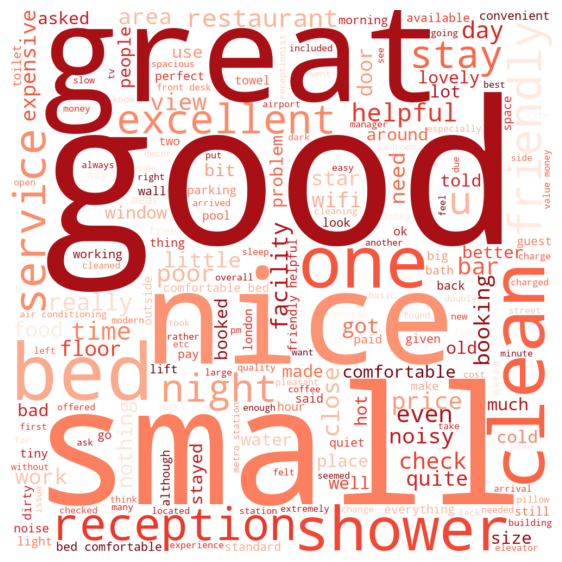

In [42]:
# WordCloud for Negative Review

wordCloud_generator(train_neg, 'white', 'Reds')

In [43]:
x = df[['Review']] 
y = df['posneg']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.9, stop_words='english')

# Fit on training data only
tfidf_train = tfidf.fit_transform(X_train['Review'])

# Transform test data
tfidf_test = tfidf.transform(X_test['Review'])

# Convert to DataFrames
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=['word_' + w for w in tfidf.get_feature_names_out()], index=X_train.index)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=['word_' + w for w in tfidf.get_feature_names_out()], index=X_test.index)

# OPTIONAL: drop old 'Review' column if you're done with it
X_train = X_train.drop(columns=['Review'])
X_test = X_test.drop(columns=['Review'])

# Concatenate TF-IDF features into X_train and X_test
X_train = pd.concat([X_train, tfidf_train_df], axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)


In [45]:
# Naive Bayes
nbmodel = GaussianNB()
nbmodel.fit(X_train, y_train)
pred_nb = nbmodel.predict(X_test)

print("Naive Bayes")
print(classification_report(y_test, pred_nb))

Naive Bayes
              precision    recall  f1-score   support

           0       0.69      0.53      0.60      1228
           1       0.63      0.78      0.70      1272

    accuracy                           0.65      2500
   macro avg       0.66      0.65      0.65      2500
weighted avg       0.66      0.65      0.65      2500



In [46]:
# Logistic Regression
lrmodel = LogisticRegression(random_state=42, max_iter=300)
lrmodel.fit(X_train, y_train)
pred_lr = lrmodel.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1228
           1       0.76      0.75      0.75      1272

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500



In [47]:
# Linear SVC
svmmodel = LinearSVC(random_state=42)
svmmodel.fit(X_train, y_train)
pred_svm = svmmodel.predict(X_test)

print("Support Vector Machine (LinearSVC)")
print(classification_report(y_test, pred_svm))

Support Vector Machine (LinearSVC)
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1228
           1       0.73      0.72      0.73      1272

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



In [48]:
tf.random.set_seed(7)

# Load data
target_ds = df.iloc[:, 0].values.astype('float32').reshape(-1, 1)  # Use only the target column

# Scale the target data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target_ds)

# Split data
train_size = int(len(scaled_target) * 0.67)
train, test = scaled_target[:train_size], scaled_target[train_size:]

In [49]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

look_back = 1 

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [50]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6698/6698 - 2s - 371us/step - loss: 0.0631
Epoch 2/10
6698/6698 - 2s - 306us/step - loss: 0.0501
Epoch 3/10
6698/6698 - 2s - 306us/step - loss: 0.0500
Epoch 4/10
6698/6698 - 2s - 296us/step - loss: 0.0500
Epoch 5/10
6698/6698 - 2s - 303us/step - loss: 0.0500
Epoch 6/10
6698/6698 - 2s - 307us/step - loss: 0.0500
Epoch 7/10
6698/6698 - 2s - 298us/step - loss: 0.0500
Epoch 8/10
6698/6698 - 2s - 295us/step - loss: 0.0500
Epoch 9/10
6698/6698 - 2s - 297us/step - loss: 0.0500
Epoch 10/10
6698/6698 - 2s - 295us/step - loss: 0.0500


In [51]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform predictions and true values
trainPredict_inv = scaler.inverse_transform(trainPredict)
testPredict_inv = scaler.inverse_transform(testPredict)
trainY_inv = scaler.inverse_transform(trainY.reshape(-1, 1))
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY_inv, trainPredict_inv))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_inv, testPredict_inv))
print('Test Score: %.2f RMSE' % (testScore))

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Train Score: 1.67 RMSE
Test Score: 1.70 RMSE
